### LLM definition

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForCausalLM, LlamaForCausalLM, AutoTokenizer #, OPTForCausalLM, AutoModelForCausalLM
from transformers import StoppingCriteria, StoppingCriteriaList

from transformers import GenerationConfig
import os
import torch

def generate_response(
    prompt,
    model = None,
    tokenizer = None,
    stopping_criteria = None,
    device = 'cuda',
    **kwargs,
    ):

    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        **kwargs,
    )
    with torch.no_grad():
        
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            stopping_criteria=stopping_criteria,
            output_hidden_states= True,
            output_scores=True,
            #output_attentions=True,
        )
        s = generation_output.sequences[0]
    output = tokenizer.decode(s)

    #print(output)

    return output, generation_output

def load_model(model_name, load_in_8_bit=False): 

    LOAD_8BIT = load_in_8_bit
    BASE_MODEL = model_name
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

    model = AutoModelForCausalLM.from_pretrained(
            BASE_MODEL,
            load_in_8bit=LOAD_8BIT,
            torch_dtype=torch.float16,
           # device_map="auto",
        )

    #model.cuda()

    if "openchat" in model.config._name_or_path:

        model.generation_config.pad_token_id = 0

    elif "Qwen" in model.config._name_or_path:
        model.generation_config.pad_token_id = 151643
    
    if not load_in_8_bit:
        model = model.cuda()
        
    return tokenizer, model 

In [2]:
#model_name =  "Nexusflow/Starling-LM-7B-beta"#"Qwen/Qwen1.5-14B"#" "h2oai/h2o-danube2-1.8b-base"#
model_name = "openchat/openchat-3.5-0106"
tokenizer, model = load_model(model_name, load_in_8_bit=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/paul/miniconda3/envs/llmagent/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/home/paul/miniconda3/envs/llmagent/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [3]:
from transformers import StoppingCriteria, StoppingCriteriaList
import torch
class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [],tokenizer= None, encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]
        self.tokenizer = tokenizer

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if self.tokenizer.decode(stop) == self.tokenizer.decode(last_token):
                return True
        return False


stop_words = ['"}', '"}\n', '"}\n\n']#, "yes", "no"] #"\nYes"

stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]

stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids, tokenizer=tokenizer)])

In [4]:
def add_and_pop_if_needed(mylist, item, max_length=8):
    # Step 2: Add the new item
    mylist.append(item)
    
    # Step 3: Check the length and remove the first item if needed
    if len(mylist) > max_length:
        mylist.pop(0)  # This removes the first item

### 
#prompt_states = []
#[add_and_pop_if_needed(prompt_states, state, max_length=8) for state in states]
#for state in states:
#    add_and_pop_if_needed(prompt_states, state, max_length=8)

In [8]:
# def parse_output(output, prompt_reason, tokenizer):

#     output =output[len(tokenizer.decode(tokenizer.encode(prompt_reason))):]
#     return output

# prompt_agent_prefix = """
# You are a telecommunications engineer tasked with selecting the best channel for the next time step based on the given interference map. The map shows the binary interference pattern for 4 channels over the past 8 time steps, where '1' indicates the channel was busy and '0' indicates it was not. Analyze the pattern and choose the channel (A-D) least likely to experience interference in the next time step.
# """
# prompt_agent_suffix= """8	x	x	x	x

# Predict the 8th row and then answer with one column that is "0" in the form "Answer: X".

# """

# interference_map = f"""
# Time Step A B C D 
# """
# for i , state in enumerate(prompt_states):

#     interference_map += f"{i+1}	{state[0]}	{state[1]}	{state[2]}	{state[3]} \n"

# #print(interference_map)
# prompt_agent = prompt_agent_prefix + interference_map + prompt_agent_suffix
# #print(prompt_agent)

# single_turn_prompt = f"GPT4 Correct User: {prompt_agent}<|end_of_turn|>GPT4 Correct Assistant: "

# MAX_NEW_TOKENS = 600
# generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
#             "do_sample": True, 
#             "num_beams" : 1, 
#             "num_return_sequences" : 1, 
#             "temperature": 0.1,# 0.8, 
#             "top_p": 0.95,
#         #  "min_new_tokens": 256, 
#         #"no_repeat_ngram_size": 12, 
#         #  "begin_suppress_tokens": [2], 
#             }
# response_text = generate_response(single_turn_prompt, model, tokenizer,**generation_args)


# output = parse_output(response_text[0], single_turn_prompt, tokenizer)
# #print("Response:", response_text[0])
# print(output)


In [9]:
import re
import json

def parse_output(output, prompt_reason, tokenizer):

    output =output[len(tokenizer.decode(tokenizer.encode(prompt_reason))):]
    return output

def extract_answer(output, pattern=  r"(.*?)(?:answer:)(.*?)(?=\r?\n|$)"): 

    ## Checks if "FINAL ANSWER" is found in the output
    #pattern = r"(.*?)(?:answer:)(.*?)(?=\r?\n|$)"
    match = re.search(pattern, output, re.DOTALL | re.IGNORECASE)

    if match:
        matched_text = match.group(0)
        matched_text = matched_text.replace("<|end_of_turn|>", "")
        matched_text = matched_text.strip()
    else:
        print("______")
        print(output)
        print("______")
    return matched_text

def add_and_pop_if_needed(mylist, item, max_length=8):
    # Step 2: Add the new item
    mylist.append(item)
    
    # Step 3: Check the length and remove the first item if needed
    if len(mylist) > max_length:
        mylist.pop(0)  # This removes the first item

def load_as_json(text):
    """
    validate and return given text as json
    """

    try:
        return json.loads(text)
    except ValueError as e:
        print("______")
        print(text)
        print("______")
        warnings.warn(f"Invalid json: {e}")

    return {}

def predict_next_action(prompt_states, model, tokenizer):
    
    # ## Three-shot examples:
    # pattern_1= """What is the pattern for the next step:
    # Time Step Channel A Channel B Channel C Channel D
    # 1 0 1 0 0
    # 2 0 0 1 0
    # 3 0 0 0 1
    # 4 1 0 0 0
    # 5 0 1 0 0
    # {"next_pattern": "0 0 1 0"}
    # """
    # pattern_2 = """Time Step Channel A Channel B Channel C Channel D
    # 1	1	1	0	0
    # 2	1	1	0	0
    # 3	0	0	1	1
    # 4	0	0	1	1
    # 5	1	1	0	0
    # {"next_pattern": "1 1 0 0"}
    # """

    # pattern_3 = """Time Step Channel A Channel B Channel C Channel D
    # 1 0 1 0 1
    # 2 1 0 1 0
    # 3 0 0 0 1
    # {"next_pattern": "1 0 1 0"}"""

    pattern_1 ="""
    Sequence 1:
    Time Step Channel A Channel B Channel C Channel D
    1| 1 1 0 0
    2| 1 1 0 0
    3| 0 0 1 1
    4| 0 0 1 1
    5| 1 1 0 0"""
    answer_1 = """{"next_row": "1 1 0 0"}"""
    
    # prompt = """
    # Sequence 2:
    # Time Step| Channel A Channel B Channel C Channel D
    # 1| 0 1 0 0
    # 2| 0 0 1 0
    # 3| 0 0 0 1
    # 4| 1 0 0 0
    # 5| 0 1 0 0
    # 6| 0 0 1 0
    # 7| 0 0 0 1
    # 8| 1 0 0 0
    # 9| 0 1 0 0
    # 10| 0 0 1 0
    # 11| 0 0 0 1
    # 12| 1 0 0 0
    # 13| 0 1 0 0
    # """


    ## Assemble the interference map at current time step 
    interference_map = f"""
    Time Step Channel A Channel B Channel C Channel D\n"""
    for i , state in enumerate(prompt_states):

        interference_map += f"{i+1}	{state[0]}	{state[1]}	{state[2]}	{state[3]} \n"

    #print(interference_map)
    #prompt_agent = prompt_agent_prefix + interference_map + prompt_agent_suffix
    prompt = interference_map #+ prompt_agent_suffix
    #print(interference_map)

    #single_turn_prompt = f"GPT4 Correct User: {prompt_agent}<|end_of_turn|>GPT4 Correct Assistant: "
    #multi_turn_prompt = f'GPT4 Correct User: START {pattern_1} END<|end_of_turn|>GPT4 Correct Assistant: {response_1}<|end_of_turn|>GPT4 Correct User: START {pattern_2} END<|end_of_turn|>GPT4 Correct Assistant: {response_2}<|end_of_turn|>GPT4 Correct User: START {prompt_agent} END<|end_of_turn|>GPT4 Correct Assistant: {{"predict"'
    #multi_turn_prompt = f'GPT4 Correct User:{prompt_agent_prefix} {pattern_1}<|end_of_turn|>GPT4 Correct Assistant: {response_1}<|end_of_turn|>GPT4 Correct User: {pattern_2}<|end_of_turn|>GPT4 Correct Assistant: {response_2}<|end_of_turn|>GPT4 Correct User: {prompt_agent}<|end_of_turn|>GPT4 Correct Assistant: {{"predict"'
    #multi_turn_prompt = f"{pattern_1}\n{pattern_2}\n{pattern_3}\n{prompt_agent}"
    multi_turn_prompt = f"GPT4 Correct User: {pattern_1}<|end_of_turn|> GPT4 Correct Assistant: {answer_1}<|end_of_turn|> GPT4 Correct User: {prompt}<|end_of_turn|>"+'GPT4 Correct Assistant: {"next_row": "'

    #print(multi_turn_prompt)
    MAX_NEW_TOKENS = 20
    generation_args = {"max_new_tokens":MAX_NEW_TOKENS,
                "do_sample": True, 
                "num_beams" : 1, 
                "num_return_sequences" : 1, 
                "temperature": 0.1,# 0.8, 
                "top_p": 0.95,
                #"min_new_tokens": 256, 
                #"no_repeat_ngram_size": 12, 
                #"begin_suppress_tokens": [2], 
                }
    #response_text = generate_response(single_turn_prompt, model, tokenizer,**generation_args)
    prompt = multi_turn_prompt + '{"next_row": "'

    print(prompt)
    response_text = generate_response(prompt, model, tokenizer,**generation_args)
    #print(prompt)
    output = parse_output(response_text[0], prompt, tokenizer)
    #print("Response:", response_text[0])

    print("LLM output:" , output)
    #output = '{"predict"'+output
    output = '{"next_row": "'+output
    #print(output)
    pattern = r'\{"predict".*?\}'
    pattern = r'\{"next_row".*?\}'
    matched_output = extract_answer(output, pattern)
    #print(matched_output)
    matched_output = load_as_json(matched_output)
    #print(matched_output)

    number_sequence = matched_output["next_row"]
    # Step 2: Split the sequence into an array
    number_array = number_sequence.split(' ')
    # Step 3: Convert each element to an integer (optional)
    number_array_int = [int(num) for num in number_array]
    # Find the index of an element that is zero
    zero_index = number_array_int.index(0)
    action = zero_index

    #mapping = {"A":0, "B":1, "C":2, "D":3}
    #action = mapping[matched_output['channel']]
    return action
prompt_states = [[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
[0, 0, 0, 1],
# [1, 0, 0, 0],
#  [0, 1, 0, 0],
#  [0, 0, 1, 0],
# [0, 0, 0, 1]
]
predict_next_action(prompt_states, model, tokenizer)

GPT4 Correct User: 
    Sequence 1:
    Time Step Channel A Channel B Channel C Channel D
    1| 1 1 0 0
    2| 1 1 0 0
    3| 0 0 1 1
    4| 0 0 1 1
    5| 1 1 0 0<|end_of_turn|> GPT4 Correct Assistant: {"next_row": "1 1 0 0"}<|end_of_turn|> GPT4 Correct User: 
    Time Step Channel A Channel B Channel C Channel D
1	1	0	0	0 
2	0	1	0	0 
3	0	0	1	0 
4	0	0	0	1 
<|end_of_turn|>GPT4 Correct Assistant: {"next_row": "
LLM output: 1 0 0 0"}<|end_of_turn|>


1

In [ ]:
LLM output: 1 0 0 0"}"}<|end_of_turn|>

In [35]:
import numpy as np
number_sequence = {"predict" : "1 0 0 0", "channel" : "A"}


In [26]:
sting = """{"predict" : "1 0 0 0", "channel" : "A"}

Based on the given time steps, it appears that the pattern in channel A repeats every 4 steps. The pattern for channel A is 1, 0, 0, 0. Therefore, at time step 9, the value for channel A would be 1.<|end_of_turn|>"""

pattern = r'\{"predict".*?\}'
match = re.search(pattern, sting, re.DOTALL | re.IGNORECASE)

if match:
    matched_text = match.group(0)

print(matched_text)
extract_answer(sting, pattern=pattern)

{"predict" : "1 0 0 0", "channel" : "A"}
\{"predict".*?\}
<re.Match object; span=(0, 40), match='{"predict" : "1 0 0 0", "channel" : "A"}'>


'{"predict" : "1 0 0 0", "channel" : "A"}'

In [65]:
#states = [state.squeeze() for state in states]
#states

### Environment

In [ ]:
import gym
from ns3gym import ns3env
from wurlitzer import pipes

# Redirect the output of the ns3gym environment creation
#with pipes() as (out, err):
env = gym.make('ns3-v0')

# Your code that uses the ns3gym environment goes here
print("ns3gym environment created successfully!")

### function

In [1]:
import numpy as np


#    state = env.reset()
    
#    state = np.reshape(state, [1, s_size])
    
def run_episode(env, model, tokenizer, max_env_steps=40, warm_up=20, max_history_length=20, random=False):
    
    if random == True:
        print(f"Running random run")
    
    else:
        print(f"Running episode for max history {max_history_length} and warm-up steps {warm_up}...")

    # Initialize the rewards and time histories
    time_history = []
    reward_history = []

    total_steps = max_env_steps # warm_up

    # Setting environment's maximum steps
    env._max_episode_steps = total_steps
    
    # Get the action and observation space sizes
    s_size = env.observation_space.shape[0]
    a_size = env.action_space.n

    #with pipes() as (out, err):
    state = env.reset()

    state = np.reshape(state, [1, s_size])
    rewardsum = 0
    states = []

    # Initialize states history
    add_and_pop_if_needed(states, state.squeeze(), max_length=max_history_length)

    for time in range(total_steps):
        print("\n")
        print("Time: ", time)
        if random or time < warm_up:
            action = np.random.randint(a_size)
            print("Action: ", action) if time < warm_up else None
        else:
            try:
                action = predict_next_action(states, model, tokenizer)
                print("LLM decision: ", action)
            except:
                print("Fallback to random action")
                action = np.random.randint(a_size)
        print("Passing action: ", action)
        next_state, reward, done, _ = env.step(action)
        print("next_state: ", next_state, " reward: ", reward)
        add_and_pop_if_needed(states, next_state.squeeze(), max_length=max_history_length)
        if time >= warm_up:
            rewardsum += reward
            
        print("__________________")
        if done:
            print(f"Time: {time}, Reward: {rewardsum}")
            #break

        #epsilon = max(epsilon * epsilon_decay, epsilon_min)  # Update epsilon
        time_history.append(time)
        reward_history.append(rewardsum)

    return time_history, reward_history


warm_ups = [0, 10, 20] #0,10,
max_lengths = [0, 10, 20] #0,10, #,30,40

results = []
random = False
for warm_up in warm_ups:
    for max_length in max_lengths:
        time_history, reward_history = run_episode(env, model, tokenizer, warm_up=warm_up, max_history_length=max_length, random=random)
        results.append({"warm_up": warm_up, "max_length": max_length, "time_history": time_history, "reward_history": reward_history, "random": random})


random = True
for i in range(3):
        time_history, reward_history = run_episode(env, model, tokenizer, warm_up=warm_up, max_history_length=max_length, random=random)
        results.append({"warm_up": 0, "max_length": 0, "time_history": time_history, "reward_history": reward_history, "random": True})


In [10]:
print("Hello")

In [38]:
import pandas as pd 
results = pd.DataFrame(results)
results#.head(5)

,warm_up,max_length,time_history,reward_history,random
0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.0, 1.0, 2.0, 3.0, 2.0, 3.0, 4.0, 5.0, ...",False
1,0,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 3.0, 4.0, 3.0,...",False
2,0,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 3.0, 4.0, 3.0,...",False
3,10,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 2.0, 3.0, ...",False
4,10,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0.0, 1.0, ...",False
5,10,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 2.0, 1.0, ...",False
6,20,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
7,20,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
8,20,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False
9,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


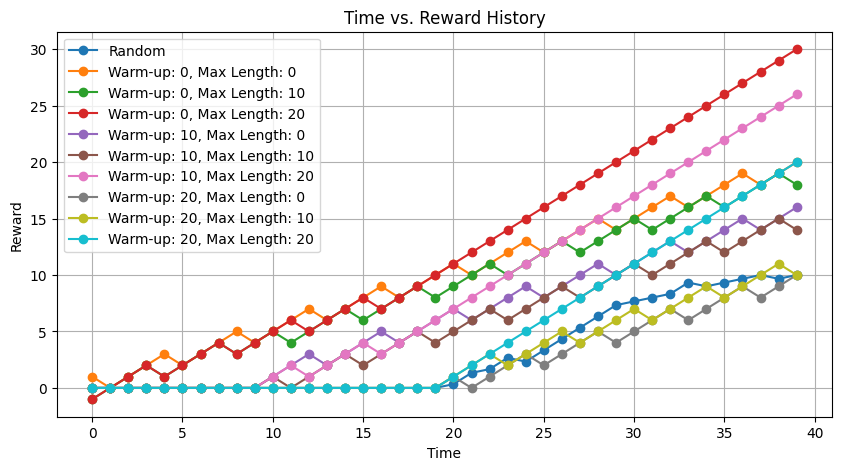

: 

In [39]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 5))

# Calculate the average reward history for random rows
random_rows = results[results['random']]
if len(random_rows) > 0:
    avg_reward_history = random_rows['reward_history'].apply(pd.Series).mean().tolist()
    plt.plot(results['time_history'].iloc[0], avg_reward_history, marker='o', linestyle='-', label='Random')

# # Calculate the average reward history for non-random rows with the same warm-up and max_length
non_random_rows = results[~results['random']]

if len(non_random_rows) > 0:
    avg_reward_history = non_random_rows.groupby(['warm_up', 'max_length'])['reward_history'].apply(
        lambda x: pd.DataFrame(x.tolist()).mean().tolist()
)
    for (warm_up, max_length), reward_history in avg_reward_history.items():
        label = f"Warm-up: {warm_up}, Max Length: {max_length}"
        plt.plot(results['time_history'].iloc[0], reward_history, marker='o', linestyle='-', label=label)

plt.title('Time vs. Reward History')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
non_random_rows
# if len(non_random_rows) > 0:
#     avg_reward_history = non_random_rows.groupby(['warm_up', 'max_length'])['reward_history'].apply(
#         lambda x: pd.Series(x.tolist()).mean().tolist()
#     )


In [26]:
results.reward_history[0]

[4.0]

In [15]:
print("lol")

In [29]:
states

[array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1]),
 array([1, 0, 0, 0])]

In [14]:
results

[{'warm_up': 0,
  'max_length': 0,
  'time_history': [49],
  'reward_history': [10.0],
  'random': True},
 {'warm_up': 0,
  'max_length': 0,
  'time_history': [49],
  'reward_history': [8.0],
  'random': True},
 {'warm_up': 0,
  'max_length': 0,
  'time_history': [49],
  'reward_history': [8.0],
  'random': True}]

In [31]:
epsilon = 1.0               # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.999

time_history = []
rew_history = []

#total_episodes = 5
max_env_steps = 20
env._max_episode_steps = max_env_steps

ob_space = env.observation_space
ac_space = env.action_space
print("Observation space: ", ob_space,  ob_space.dtype)
print("Action space: ", ac_space, ac_space.n)

s_size = ob_space.shape[0]
a_size = ac_space.n
total_episodes = 1
import numpy as np
random = False
warm_up = 20

max_env_steps = max_env_steps + warm_up

reward_history = []
time_history = []
for e in range(total_episodes):

    state = env.reset()
    
    state = np.reshape(state, [1, s_size])
    
    #print(state)
    rewardsum = 0
    states = []
    add_and_pop_if_needed(states, state.squeeze(), max_length=5)
    for time in range(max_env_steps):
        print("\n")
        print("Time: ", time)
        if random :
            action = np.random.randint(a_size)
            print("Random Action: ", action)
        else:
            try: 
                action = predict_next_action(states, model, tokenizer)

                print("LLM decision: ", action)

            except: 
                print("Fallback to random action")
                action = np.random.randint(a_size)
        # Step
        next_state, reward, done, _ = env.step(action)
        print("Observation: ", next_state, " Reward: ", reward)
        if done:
            print("episode: {}/{}, time: {}, rew: {}, eps: {:.2}"
                .format(e, total_episodes, time, rewardsum, epsilon))
            break
        #states.append(next_state.squeeze())
        add_and_pop_if_needed(states, next_state.squeeze(), max_length=20)
        #next_state = np.reshape(next_state, [1, s_size])
        
        #state = next_state
        print("__________________")
        if time < warm_up:
            #print("lol")
            continue
        rewardsum += reward
        #print("Reward: ", rewardsum)
        time_history.append(time)
        reward_history.append(rewardsum)

Observation space:  Box(0, 1, (4,), uint64) uint64
Action space:  Discrete(4) 4
Got new port for ns3gm interface:  9750
Start command:  /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/ns3 run "interference-pattern --openGymPort=9750 --simSeed=1660217934"
Started ns3 simulation script, Process Id:  60171
/usr/bin/cmake -P /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles/VerifyGlobs.cmake
/usr/bin/cmake -S/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1 -B/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache --check-build-system CMakeFiles/Makefile.cmake 0
/usr/bin/gmake  -f CMakeFiles/Makefile2 interference-pattern
gmake[1]: Entering directory '/home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache'
/usr/bin/cmake -P /home/paul/pauld/projects/satne/llmnetwork/ns-allinone-3.36.1/ns-3.36.1/cmake-cache/CMakeFiles/VerifyGlobs.cmake
/usr/bin/

Ns3Env parameters:
--simulationTime: 10
--openGymPort: 9750
--envStepTime: 0.1
--seed: 1660217934
--testArg: 0
Simulation start
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
GetObservationSpace:  BoxSpace Low: 0 High: 1 Shape: (4,) Dtype: uint32_t
GetActionSpace:  DiscreteSpace N: 4
Simulation process id: 60312 (parent (waf shell) id: 60172)
Waiting for Python process to connect on port: tcp://localhost:9750
Please start proper Python Gym Agent
MyGetObservation: [1, 0, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 1 0 0]  Reward:  -1.0
__________________


Time:  1


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 1"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  2


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  3


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  4


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 1 0 0]  Reward:  -1.0
__________________


Time:  5


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  6


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  7


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  8


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 1 0 0]  Reward:  -1.0
__________________


Time:  9


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  10


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  11


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  12


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 1 0 0]  Reward:  -1.0
__________________


Time:  13


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  14


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  15


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  16


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [0 1 0 0]  Reward:  -1.0
__________________


Time:  17


Current Channel: 1
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: -1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  18


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  19


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  20


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 1 0 0]  Reward:  1.0
__________________


Time:  21


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  22


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  23


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  24


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 1 0 0]  Reward:  1.0
__________________


Time:  25


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  26


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  27


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  28


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 1 0 0]  Reward:  1.0
__________________


Time:  29


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  30


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  31


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  32


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 1 0 0]  Reward:  1.0
__________________


Time:  33


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  34


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  35


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Time:  36


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 1 0 0"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 1 0 0]  Reward:  1.0
__________________


Time:  37


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9895
Channel: 1 CCA: 1 RxPower: -56.6436
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 1, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 1 0"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 1 0]  Reward:  1.0
__________________


Time:  38


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9895
Channel: 2 CCA: 1 RxPower: -56.6436
Channel: 3 CCA: 0 RxPower: -76.9897
MyGetObservation: [0, 0, 1, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 0 0 0 1"}"}<|end_of_turn|>
LLM decision:  0
Observation:  [0 0 0 1]  Reward:  1.0
__________________


Time:  39


Current Channel: 0
Channel: 0 CCA: 0 RxPower: -76.9897
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9895
Channel: 3 CCA: 1 RxPower: -56.6436
MyGetObservation: [0, 0, 0, 1]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


LLM output: 1 0 0 0"}"}<|end_of_turn|>
LLM decision:  1
Observation:  [1 0 0 0]  Reward:  1.0
__________________


Current Channel: 1
Channel: 0 CCA: 1 RxPower: -56.6436
Channel: 1 CCA: 0 RxPower: -76.9897
Channel: 2 CCA: 0 RxPower: -76.9897
Channel: 3 CCA: 0 RxPower: -76.9895
MyGetObservation: [1, 0, 0, 0]
MyGetReward: 1
MyGetGameOver: 0
MyGetExtraInfo: {'info': 'extra_info'}


In [18]:
rewardsum

4.0

In [20]:
rewardsum

4.0

In [24]:
rewardsum

20.0

In [17]:
reward_history

[1.0,
 2.0,
 3.0,
 4.0,
 3.0,
 4.0,
 5.0,
 6.0,
 5.0,
 6.0,
 7.0,
 8.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 11.0,
 12.0]

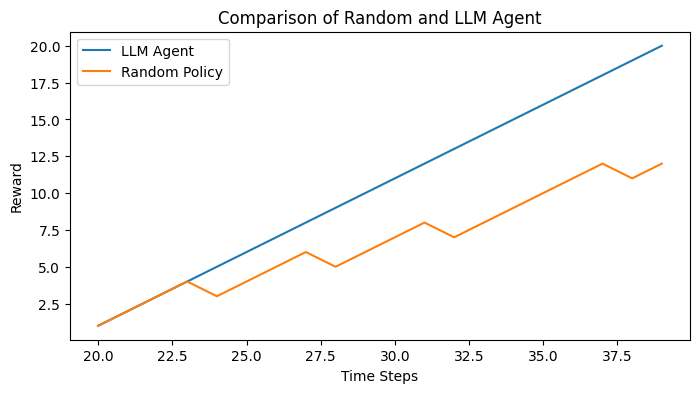

In [22]:
import matplotlib.pyplot as plt

# Example data
x = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]  # Common x-axis values
y_llm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]  # Data row 1
y_random = [1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 6.0, 5.0, 6.0, 7.0, 8.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 11.0, 12.0]  # Data row 2

# Create a figure and an axes.
plt.figure(figsize=(8, 4))
plt.plot(x, y_llm, label='LLM Agent')  # Plot the first line with label
plt.plot(x, y_random, label='Random Policy')  # Plot the second line with label

# Adding title and labels
plt.title('Comparison of Random and LLM Agent')
plt.xlabel('Time Steps')
plt.ylabel('Reward')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [20]:
#!pip install matplotlib

In [11]:
time_history

[20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

### 

In [26]:
rewardsum

10.0

In [13]:
rewardsum

20.0